max pooling -> GlobalAveragePooling 레이어로 변경 ( 2017 cs231n lecture 9 참고)

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import math
import os

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## cifar-10 데이터셋 다운로드

In [3]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

## 데이터셋 확인

In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [5]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


## 255로 정규화 하여 0~1사이의 값 만들기

In [6]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )

    ds = ds.batch(batch_size)
    if not is_test: # if is_test == Fasle :
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

* 데이터 클래스 10개

In [8]:
ds_info.features["label"].num_classes

10

In [9]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

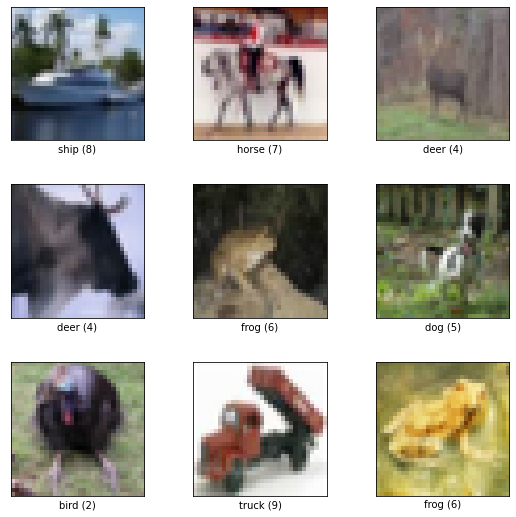

In [10]:
fig = tfds.show_examples(ds_train, ds_info)

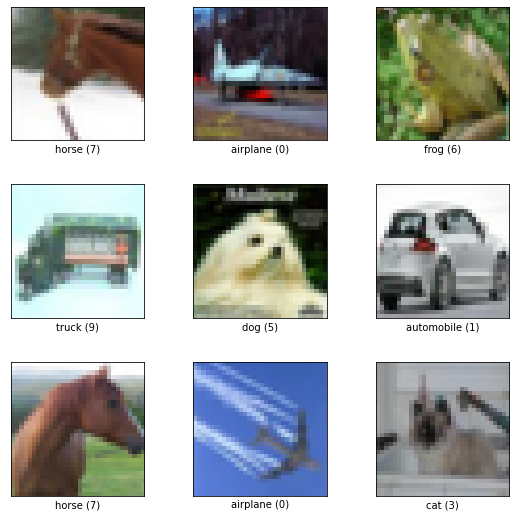

In [11]:
fig = tfds.show_examples(ds_test, ds_info)

# ResNet 만들기

## ResNet34
- residual block 이 34개 쌓은 ResNet 모델이다.

In [1]:
#input_tensor = Input(shape=(32, 32, 3), dtype='float32', name='input')

def Conv1_Layer(x):    
    x = keras.layers.ZeroPadding2D(padding=(3, 3))(x)
    x = keras.layers.Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.ZeroPadding2D(padding=(1,1))(x)
    return x    
 
# 각 stage마다 첫번째 block은 이전 stage에서 받아온 텐서의 dimension을 증가시켜야 하기 때문에(뒤에서 add연산 하기 위해) if문으로 처리하였다.
def Conv2_Layer(x):         
    x = keras.layers.MaxPooling2D((3, 3), 2)(x)     
    shortcut = x
    for i in range(3):
            x = keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
 
            x = keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)            
 
            x = keras.layers.Add()([x, shortcut])   
            x = keras.layers.Activation('relu')(x)  
 
            shortcut = x        
    return x
 
def Conv3_Layer(x):     
    shortcut = x    
    for i in range(4):     
        if(i == 0):            
            x = keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)        
            
            x = keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            shortcut = keras.layers.Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(shortcut) #확인 필요
            x = keras.layers.BatchNormalization()(x)
            shortcut = keras.layers.BatchNormalization()(shortcut)            
 
            x = keras.layers.Add()([x, shortcut])    
            x = keras.layers.Activation('relu')(x)    
 
            shortcut = x              
        
        else:
            x = keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
            
            x = keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            #x = Activation('relu')(x)
 
            x = keras.layers.Add()([x, shortcut])     
            x = keras.layers.Activation('relu')(x)
 
            shortcut = x      
            
    return x
 
def Conv4_Layer(x):
    shortcut = x        
    for i in range(6):     
        if(i == 0):                        
            x = keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)  
 
            x = keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            shortcut = keras.layers.Conv2D(256, (1, 1), strides=(2, 2), padding='same')(shortcut)
            x = keras.layers.BatchNormalization()(x)
            shortcut = keras.layers.BatchNormalization()(shortcut)
 
            x = keras.layers.Add()([x, shortcut]) 
            x = keras.layers.Activation('relu')(x)
 
            shortcut = x               
        
        else:
            x = keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
            
            x = keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            #x = Activation('relu')(x)
 
            x = keras.layers.Add()([x, shortcut])    
            x = keras.layers.Activation('relu')(x)
 
            shortcut = x      
    return x
 
def Conv5_Layer(x):

    shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = keras.layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)        

            x = keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            shortcut = keras.layers.Conv2D(512, (1, 1), strides=(2, 2), padding='same')(shortcut)
            x = keras.layers.BatchNormalization()(x)
            shortcut = keras.layers.BatchNormalization()(shortcut)            
 
            x = keras.layers.Add()([x, shortcut])  
            x = keras.layers.Activation('relu')(x)      
 
            shortcut = x               
        
        else:
            x = keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
 
            x = keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)           
            
            x = keras.layers.Add()([x, shortcut]) 
            x = keras.layers.Activation('relu')(x)       
 
            shortcut = x                  
 
    return x
 


In [13]:
res_input_layer = keras.layers.Input(shape=(32,32,3))

In [14]:
K=10

x = Conv1_Layer(res_input_layer)
x = Conv2_Layer(x)
x = Conv3_Layer(x)
x = Conv4_ㅣayer(x)
x = Conv5_layer(x)
 
x = keras.layers.GlobalAveragePooling2D()(x)
res_block_output = keras.layers.Dense(K, activation='softmax')(x)

In [15]:
# 블록 1개짜리 model 생성
model_res34 = keras.Model(inputs=res_input_layer, outputs=res_block_output)  

model_res34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
______________________________________________________________________________________________

# ResNet_50

In [ ]:
def Conv1_Layer(x):    
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)
 
    return x   
 
def Conv2_Layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)     
    shortcut = x
    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
 
        else:
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
 
            shortcut = x        
    
    return x
 
def Conv3_Layer(x):        
    shortcut = x    
    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)    
 
            shortcut = x              
        
        else:
            x = Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])     
            x = Activation('relu')(x)
 
            shortcut = x      
            
    return x
 
def Conv4_Layer(x):
    shortcut = x        
  
    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(1024, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
 
            shortcut = x               
        
        else:
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)
 
            shortcut = x      
 
    return x
 
def Conv5_Layer(x):
    shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(2048, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])  
            x = Activation('relu')(x)      
 
            shortcut = x               
        
        else:
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)           
            
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)       
 
            shortcut = x                  
 
    return x

In [ ]:
res_input_layer = keras.layers.Input(shape=(32,32,3))

Res block을 여러개 쌓아 모델 만들기

In [16]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

In [17]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

In [18]:
BATCH_SIZE = 256
EPOCH = 20

In [19]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)


In [20]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)

In [21]:
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [22]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
195/195 [==============================] - 48s 163ms/step - loss: 2.2490 - accuracy: 0.1511 - val_loss: 2.0731 - val_accuracy: 0.2580
Epoch 2/20
195/195 [==============================] - 17s 90ms/step - loss: 2.0302 - accuracy: 0.2557 - val_loss: 1.8969 - val_accuracy: 0.3200
Epoch 3/20
195/195 [==============================] - 18s 95ms/step - loss: 1.8945 - accuracy: 0.3136 - val_loss: 1.8004 - val_accuracy: 0.3587
Epoch 4/20
195/195 [==============================] - 18s 95ms/step - loss: 1.7761 - accuracy: 0.3569 - val_loss: 1.6903 - val_accuracy: 0.3979
Epoch 5/20
195/195 [==============================] - 18s 93ms/step - loss: 1.6917 - accuracy: 0.3912 - val_loss: 1.6422 - val_accuracy: 0.4062
Epoch 6/20
195/195 [==============================] - 19s 96ms/step - loss: 1.6234 - accuracy: 0.4124 - val_loss: 1.5908 - val_accuracy: 0.4125
Epoch 7/20
195/195 [==============================] - 19s 96ms/step - loss: 1.5787 - accuracy: 0.4294 - val_loss: 1.5668 - val_accuracy

In [23]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
195/195 [==============================] - 21s 95ms/step - loss: 2.2665 - accuracy: 0.1464 - val_loss: 2.1313 - val_accuracy: 0.2077
Epoch 2/20
195/195 [==============================] - 19s 95ms/step - loss: 2.1069 - accuracy: 0.2221 - val_loss: 1.9990 - val_accuracy: 0.2947
Epoch 3/20
195/195 [==============================] - 19s 95ms/step - loss: 1.9567 - accuracy: 0.2888 - val_loss: 1.8523 - val_accuracy: 0.3568
Epoch 4/20
195/195 [==============================] - 19s 96ms/step - loss: 1.8137 - accuracy: 0.3460 - val_loss: 1.7344 - val_accuracy: 0.3709
Epoch 5/20
195/195 [==============================] - 19s 95ms/step - loss: 1.7021 - accuracy: 0.3831 - val_loss: 1.6316 - val_accuracy: 0.4089
Epoch 6/20
195/195 [==============================] - 19s 96ms/step - loss: 1.6363 - accuracy: 0.4070 - val_loss: 1.6123 - val_accuracy: 0.4313
Epoch 7/20
195/195 [==============================] - 19s 96ms/step - loss: 1.5829 - accuracy: 0.4253 - val_loss: 1.5064 - val_accuracy:

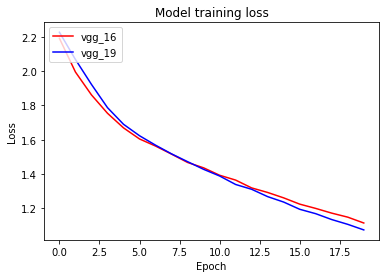

In [24]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

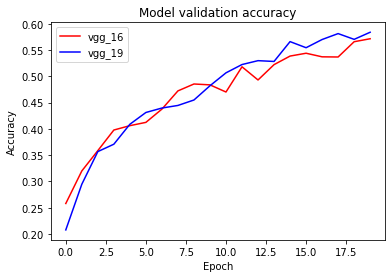

In [25]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

In [26]:
resnet_34 = build_resnet(input_shape=(32, 32,3), is_50=False)
resnet_34.summary()

NameError: name 'build_resnet' is not defined

In [ ]:
resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True)
resnet_50.summary()

1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?

블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.
2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?

cats_vs_dogs 데이터셋으로 학습시 몇 epoch동안 안정적으로 loss 감소가 진행 확인되었다.
3. Ablation Study 결과가 바른 포맷으로 제출되었는가?

ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.